# Programming Languages Analysis

The PLDB is a large database containing infomation on thousands on programming languages, operating systems, equations and far more things relating to computer science. It can be found at https://pldb.io/csv.html, and is where this data was sourced from. It has a very wide range of information about each item, ranging from creators to specific features to how it has performed on specific websties. This gives us a way to be able to look at these langauges to try and learn more about how langauges are created in general, as well as comparisons between them. 

I aim to answers a few question in 3 different main areas:
- Which are the most popular languages and does this depend on the 'metric' we use the gauge popularity?
- Where and when did most languages originate? 
- Do certain feautures always tend to appear in the most popular languages and there some features which are ubiquitous?

Before we are able to consider these questions though, we first need to clean up the dataset, since it is very large and there are a lot of practically empty columns as well as columns which are either irrelvant or difficult to do analysis on. A few columns also should be split out, as they contain lots of pieces of infomation store in one column making it difficult to see general trends.


## Data Overview

We begin by importing  all the necessary libraries, reading in the dataset from github, and looking at the first couple of lines to get a picture of the data. 

In [1]:
# Import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SyntaxWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.offsetbox as mbox
import seaborn as sns
import re 
import circlify
import scipy
import geopandas

# some stylistic constants so diagrams have consistency
PASTELS = sns.color_palette('pastel')
COLOUR_SET = sns.color_palette('Dark2',n_colors=15)
TITLE_FONT = dict(fontweight="bold",fontsize=14)

After a few attempts where there was an issue with reading in the lines, I found that in the stringToken column, as lot of values had a " character without a pair. This caused an issue for the parsers, so I replaced all instances of these in the csv file with \\". This made sure the csv became readable and from looking at the shape we appear to have successfully translated all the rows, as the documentation tells us there should be 5008 instances of id, which is exactly the number of rows we have. We also can see there are 393 columns so it would probably be helpful to strip these down, as not all of them will be useful, and this is a lot of columns to deal with.

In [2]:
# Read in data
df = pd.read_csv('../csv files/pldb.csv',sep=',',low_memory=False)
print(f"Shape of the dataframe :  {df.shape}")
df.head()

Shape of the dataframe :  (5008, 393)


,id,name,appeared,creators,maintainers,measurements,tags,rijuRepl_website,website,spec,...,githubBigQuery,linguistGrammarRepo,hackerNewsDiscussions,isbndb,githubLanguage,indeedJobs,linkedInSkill,stackOverflowSurvey,semanticScholar,goodreads
0,javascript,JavaScript,1995,Brendan Eich,NaN,143,pl,NaN,NaN,https://ecma-international.org/publications-an...,...,JavaScript,https://github.com/atom/language-javascript,NaN,year|publisher|title|authors|isbn13\n2014|Wile...,JavaScript,javascript developer,javascript,NaN,year|title|doi|citations|influentialCitations|...,title|year|author|goodreadsId|rating|ratings|r...
1,c,C,1972,Dennis Ritchie,NaN,98,pl,NaN,NaN,https://www.iso-9899.info/wiki/The_Standard,...,C,https://github.com/textmate/c.tmbundle,NaN,year|publisher|title|authors|isbn13\n2003|McGr...,C,c engineer,c,NaN,year|title|doi|citations|influentialCitations|...,NaN
2,python,Python,1991,Guido van Rossum,NaN,119,pl,https://www.python.org/,https://www.python.org/,https://docs.python.org/3/reference/,...,Python,https://github.com/tree-sitter/tree-sitter-python,NaN,year|publisher|title|authors|isbn13\n2014|No S...,Python,python engineer,python,NaN,year|title|doi|citations|influentialCitations|...,title|year|author|goodreadsId|rating|ratings|r...
3,java,Java,1995,James Gosling,NaN,108,pl,NaN,https://openjdk.org/,https://docs.oracle.com/javase/specs/,...,Java,https://github.com/textmate/java.tmbundle,NaN,year|publisher|title|authors|isbn13\n2017|Pear...,Java,java engineer,java,NaN,year|title|doi|citations|influentialCitations|...,title|year|author|goodreadsId|rating|ratings|r...
4,cpp,C++,1985,Bjarne Stroustrup,NaN,78,pl,NaN,http://isocpp.org/,https://isocpp.org/std/the-standard,...,C++,https://github.com/textmate/c.tmbundle,NaN,year|publisher|title|authors|isbn13\n2011|PEAR...,C++,c++ engineer,c++,NaN,year|title|doi|citations|influentialCitations|...,NaN


Before we start dealing with the columns, it's worth considering what we want to achieve with this analysis. I'm mainly interested in programming langauges, but this dataset contain lots of things which aren't in that category such as equations, operating systems, editors and notation. We use the tags column to remove anything which isn't tagged with 'pl' somewhere. I also replace "Arduino Programming Language" with "Arduino PL" to make some of the graphs involving it less clunky.

In [3]:
pat = re.compile(r'pl')
valid_tags = [i for i in df['tags'].unique() if pat.match(i)] + ['queryLanguage','textMarkup']

df = df[df['tags'].isin(valid_tags)]
df['name'] = df['name'].replace({"Arduino Programming Language" : "Arduino PL"})
df.shape

(3632, 393)

In order to thin out the columns, firstly we should consider the number of NaN values in each column. From looking at the documentation, there are a lot of columns with less than 5% of the values filled out. There are some issues with the approach of just removing all these columns though, as some of them are booleans and it's possible that the NaN values should just be replaced with false. It's worth looking into these columns to see how they have been filled out. As an example we look at a couple of the feature columns.

In [4]:
df[['hasForLoops','hasExports','hasDynamicTyping','hasConditionals']].agg(pd.value_counts)

,hasForLoops,hasExports,hasDynamicTyping,hasConditionals
False,NaN,NaN,NaN,1
True,7.0,2.0,2.0,67


Clearly filling in the NaNs with just False would not be a good way to deal with this, as it's extremely unlikely so many languages are lacking for loops, exports, dynamic typing and conditionals. As a result it would probably just be best to remove all the columns with less than 5% of the values filled, as was originally the plan, since it will be extremely difficult to salvage any of these sparsely populated columns without finding a source to accurately fill in the columns for us.

In [5]:
## REMOVE EMPTY COLUMNS
boundary = df.shape[0] * 0.95
null_counts = df.isnull().sum()
sparse_cols = null_counts[null_counts >= boundary].index.to_list()
df.drop(columns=sparse_cols,inplace=True)
df.shape  ## Current shape

(3632, 106)

In [6]:
df.columns    ## Current columns

Index(['id', 'name', 'appeared', 'creators', 'measurements', 'tags', 'website',
       'foundationScore', 'latestVersion', 'exampleCount',
       ...
       'bookCount', 'paperCount', 'hopl', 'tiobe', 'domainName',
       'githubBigQuery', 'linguistGrammarRepo', 'isbndb', 'githubLanguage',
       'semanticScholar'],
      dtype='object', length=106)

In [7]:
df.head()

,id,name,appeared,creators,measurements,tags,website,foundationScore,latestVersion,exampleCount,...,bookCount,paperCount,hopl,tiobe,domainName,githubBigQuery,linguistGrammarRepo,isbndb,githubLanguage,semanticScholar
0,javascript,JavaScript,1995,Brendan Eich,143,pl,NaN,505,es14,5,...,351.0,48.0,https://hopl.info/showlanguage.prx?exp=2133,JavaScript,NaN,JavaScript,https://github.com/atom/language-javascript,year|publisher|title|authors|isbn13\n2014|Wile...,JavaScript,year|title|doi|citations|influentialCitations|...
1,c,C,1972,Dennis Ritchie,98,pl,NaN,394,C17,5,...,78.0,19.0,https://hopl.info/showlanguage.prx?exp=577,C,NaN,C,https://github.com/textmate/c.tmbundle,year|publisher|title|authors|isbn13\n2003|McGr...,C,year|title|doi|citations|influentialCitations|...
2,python,Python,1991,Guido van Rossum,119,pl,https://www.python.org/,388,3.12.3,3,...,342.0,52.0,https://hopl.info/showlanguage.prx?exp=1658,Python,python.org,Python,https://github.com/tree-sitter/tree-sitter-python,year|publisher|title|authors|isbn13\n2014|No S...,Python,year|title|doi|citations|influentialCitations|...
3,java,Java,1995,James Gosling,108,pl,https://openjdk.org/,137,20,6,...,401.0,37.0,https://hopl.info/showlanguage.prx?exp=2131,Java,NaN,Java,https://github.com/textmate/java.tmbundle,year|publisher|title|authors|isbn13\n2017|Pear...,Java,year|title|doi|citations|influentialCitations|...
4,cpp,C++,1985,Bjarne Stroustrup,78,pl,http://isocpp.org/,282,C++20,6,...,128.0,6.0,https://hopl.info/showlanguage.prx?exp=1202,C++,isocpp.org,C++,https://github.com/textmate/c.tmbundle,year|publisher|title|authors|isbn13\n2011|PEAR...,C++,year|title|doi|citations|influentialCitations|...


This has greatly reduced the number of columns, down to 106, but there are still quite a lot which are in no way helpful e.g the urls and names of books/papers about the language. To get rid of the columns filled with hyperlinks,we will first replace any URLs with NaN and then remove any columns which have become sparse due to this, similarly to before. We also remove a few columns which we visually see are not particularly useful, such as descriptions, version numbers, example snippets and file extension infomation.

In [8]:
df = df.replace(r"(^https://)|(^http://)",np.NaN,regex=True)
null_counts2 = df.isnull().sum()
sparse_cols2 = null_counts2[null_counts2 >= boundary].index.to_list()
extra_cols_to_drop = ['latestVersion','isbndb','semanticScholar','latestMajorVersion','wikipedia_summary','description',
       'githubRepo_description', 'rijuRepl_description', 'githubLanguage_fileExtensions', 'leachim6_fileExtensions',
       'pygmentsHighlighter_fileExtensions', 'linguistGrammarRepo_example', 'wikipedia_example', 'leachim6_example','example','domainName',
       'leachim6_filepath','fileType','tiobe','hasMultiLineComments']
df.drop(columns= [*sparse_cols2, *extra_cols_to_drop],inplace=True)
df.head()

,id,name,appeared,creators,measurements,tags,foundationScore,exampleCount,rank,lastActivity,...,stringToken,hasComments,hasLineComments,hasPrintDebugging,hasSemanticIndentation,hasStrings,bookCount,paperCount,githubBigQuery,githubLanguage
0,javascript,JavaScript,1995,Brendan Eich,143,pl,505,5,1,2022,...,`,True,True,True,False,True,351.0,48.0,JavaScript,JavaScript
1,c,C,1972,Dennis Ritchie,98,pl,394,5,2,2022,...,NaN,True,True,True,False,True,78.0,19.0,C,C
2,python,Python,1991,Guido van Rossum,119,pl,388,3,3,2024,...,NaN,True,True,True,True,True,342.0,52.0,Python,Python
3,java,Java,1995,James Gosling,108,pl,137,6,4,2024,...,"'\""'",True,True,True,False,True,401.0,37.0,Java,Java
4,cpp,C++,1985,Bjarne Stroustrup,78,pl,282,6,5,2022,...,"'\""'",NaN,NaN,NaN,NaN,NaN,128.0,6.0,C++,C++


Finally we are down to the 77 columns which may be useful in our analysis. The table below names them all, and colour codes them according to what sort of information they convey.

In [9]:
colour_mapping = dict(zip(['github','wikipedia','repoStats','linguist','is','has','uses',None],[0,1,2,3,4,4,4,6]))

def colouring(x):
    match = re.search(r'(^github)|(^wikipedia)|(^repoStats)|(^linguist)|(^is)|(^has)|(^uses)',x)
    if match is not None:
        return PASTELS[colour_mapping[match.group(0)]]
    return PASTELS[colour_mapping[None]]

def format(x):
    if len(x) > 29:
        s = x.split("_")
        return f"{s[0]}_\n{s[1]}"
    return x

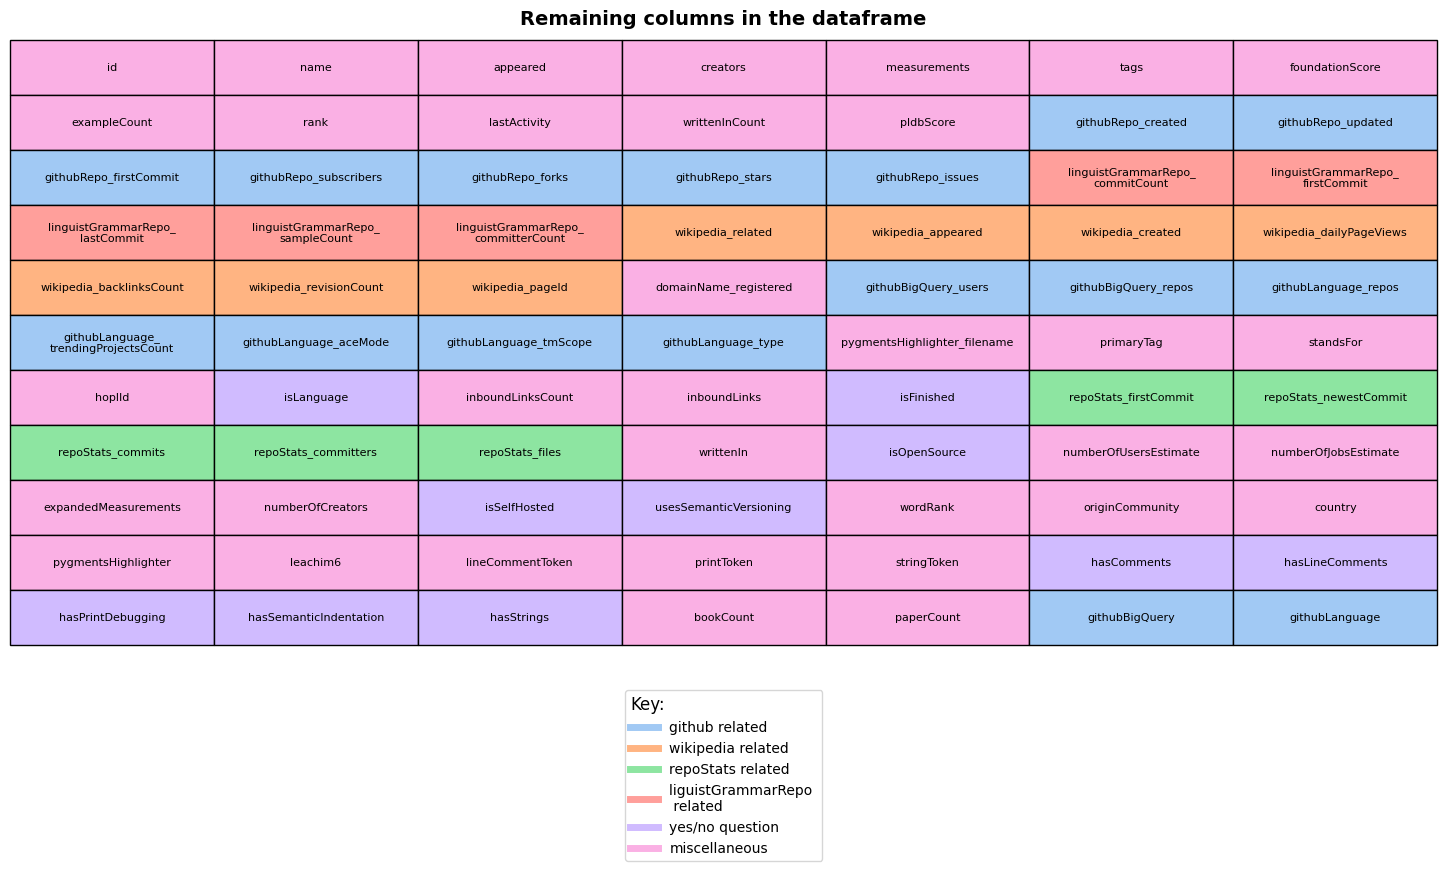

In [10]:
fig1,ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [3,1]},figsize=(15,9))
[ax1,ax2] = ax.ravel()
ax1.axis('off') ; fig1.tight_layout()
ax1.set_title("Remaining columns in the dataframe",**TITLE_FONT)

colours_set = np.array(list(map(colouring,df.columns)),dtype="f,f,f").reshape(-1,7)
formatted_columns = np.array(list(map(format,df.columns))).reshape(-1,7)
table = ax1.table(cellText=formatted_columns, cellColours = colours_set ,loc='center',cellLoc='center')
table.auto_set_font_size(False); table.set_fontsize(8); table.scale(1,3.3)

handles = [plt.Line2D([0], [0], c=x,linewidth=5) for x in [*PASTELS[0:5],PASTELS[6]]]
ax2.legend(handles=handles,labels=['github related','wikipedia related','repoStats related','liguistGrammarRepo \n related','yes/no question','miscellaneous'],
           loc='center',title="Key:",title_fontsize=12,alignment='left')
ax2.axis('off'); 

Before we start manipulating the data we should ensure every column is of the correct type as we see that only 2 columns are classed as booleans, when from the table of columns we know that there are definitely more. We note we are left with a lot of float columns that we would rather be ints, but since they are filled with NaNs and it wouldn't be right to just fill these with 0s (as it wouldn't be very accurate to the truth), so we will just leave them be for now.

In [11]:
df.dtypes.value_counts()

float64    34
object     30
int64      11
bool        2
Name: count, dtype: int64

In [12]:
boolColumns = ['hasComments', 'hasLineComments', 'hasPrintDebugging', 'hasSemanticIndentation', 'hasStrings',
               'isFinished', 'isLanguage','isOpenSource','isSelfHosted','usesSemanticVersioning']
df[boolColumns] = df[boolColumns].astype(bool)

Ideally we should also seperate out the creators column, since some languages have more than one creator, leaving us with a total of 88 columns (as we drop the orignal creators column)

In [13]:
creator_list = [f"creator{x}" for x in np.arange(0,13)]
df[creator_list] = df['creators'].str.split(pat=' and ',n=12,expand=True).fillna(value=np.nan)
df.drop(columns=['creators'],inplace=True)
df

,id,name,appeared,measurements,tags,foundationScore,exampleCount,rank,lastActivity,writtenInCount,...,creator3,creator4,creator5,creator6,creator7,creator8,creator9,creator10,creator11,creator12
0,javascript,JavaScript,1995,143,pl,505,5,1,2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c,C,1972,98,pl,394,5,2,2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,python,Python,1991,119,pl,388,3,3,2024,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,java,Java,1995,108,pl,137,6,4,2024,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cpp,C++,1985,78,pl,282,6,5,2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,zccs,ZCCS,1997,6,pl,0,0,4995,1997,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4995,zgrass,ZGRASS,1978,6,pl,0,0,4996,1978,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4996,arbortext-command-language,arbortext-command-language,2009,5,pl,0,0,4997,2009,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,concordance,concordance,1994,5,pl,0,0,4998,1994,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We also clean up the stringToken column, as it still has additional backslashes added to help us read in the csv

In [14]:
df['stringToken'] = df['stringToken'].replace("\'\\\"\'",'"')

Lastly, we make an additional dataframe which expands out and correctly formats each countries name in alignment with the names used by a .shp file containing the countries of the world. This will let us easily merge with the file later.

In [15]:
countries = df[['name','country']].copy()
country_replacements = {
    **dict.fromkeys(['United Kingdom','Great Britain','Scotland, United Kingdom','Scotland', 'England', 'N. Ireland','Wales'],'U.K. of Great Britain and Northern Ireland'),
    **dict.fromkeys(['Russia','Union of Soviet Socialist Republics or Russia','Former USSR','Former USSR or Russia'], 'Russian Federation'),
    **dict.fromkeys(['United State','United States', 'USA'],'United States of America'),
    **dict.fromkeys(['Former West Germany or Germany','Former West Germany or Federal Republic of Germany','Federal Republic of Germany'],'Germany'),
    **dict.fromkeys(['Czechia','The Czech Republic'],'Czech Republic'),
    **dict.fromkeys(['South Korea','Korea','Japan or Korea'],'Republic of Korea'),
     'Former USSR or Latvia': 'Latvia',
     'Former Union of Soviet Socialist Republics or Estonia' : 'Estonia',
     'Italia' :'Italy',
     'The Netherlands': 'Netherlands',
     'Dubai' :'United Arab Emirates',
     'Hong Kong (SAR)' : 'Hong Kong',
     'Taiwan or R.O.C' : 'Taiwan',
     "People's Republic of China" :  'China',
     'Brasil':'Brazil',
     'Iran' : 'Iran (Islamic Republic of)',
     'North Cyprus':'Cyprus'}

countries['country'] = countries['country'].replace({' amd ': ' and '},regex=True)
countries[['1','2','3','4','5','6']] = countries['country'].str.split(pat=' and ',n=6,expand=True).fillna(value=np.nan)
countries[['1','2','3','4','5','6']] = countries[['1','2','3','4','5','6']].map(lambda x: x.strip() if isinstance(x, str) else x).replace(country_replacements)
countries.head()

,name,country,1,2,3,4,5,6
0,JavaScript,United States,United States of America,NaN,NaN,NaN,NaN,NaN
1,C,United States,United States of America,NaN,NaN,NaN,NaN,NaN
2,Python,Netherlands,Netherlands,NaN,NaN,NaN,NaN,NaN
3,Java,United States,United States of America,NaN,NaN,NaN,NaN,NaN
4,C++,United States,United States of America,NaN,NaN,NaN,NaN,NaN


## Which are the most popular programming languages?

The first question I want to look at is to see which langauges are the most popular. There are a number of different metrics we could measure this by available to us in the dataset so we can look at each of these individually and see if there is a group of languages, or one in particular, which stands out as the most popular.

To begin, the most natural way for us to measure popularity would be to look at the number of users, as we have below (it's worth noting that this value is an estimate and may not be entirely accurate). SQL tops the rankings, swiftly followed by JavaScript and Java as would be expected. Python follows shortly after, beaten by both C and C++. A lot of maths/statistics based langauges also appear, with MATLAB, R and SPSS all doing well. 

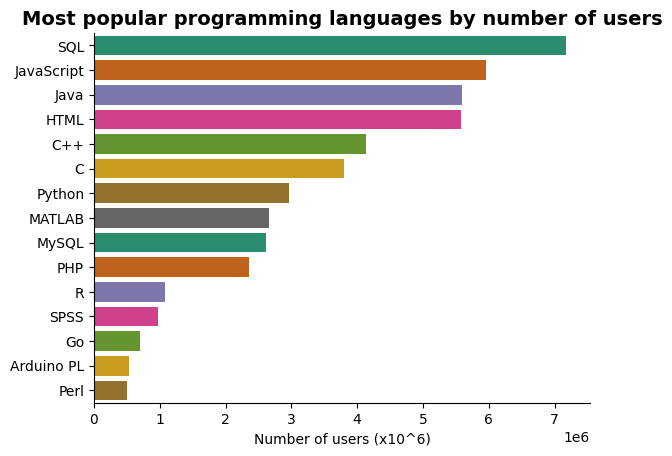

In [16]:
## most number of users 
most_used_df = df.nlargest(15,'numberOfUsersEstimate',keep='all')
ax = sns.barplot(x=most_used_df['numberOfUsersEstimate'],y=most_used_df['name'],hue=most_used_df['name'],palette=COLOUR_SET)
ax.set_title("Most popular programming languages by number of users",**TITLE_FONT)
ax.set_xlabel("Number of users (x10^6)")
ax.set_ylabel("")
ax.spines[['right', 'top']].set_visible(False)

An interesting comparison we can make is to look at the number of users of a langauges vs the number of jobs which purport to use that language. This gives us some insight into the popularity of the language professionally. We see that SQL has by far the most jobs associated with it, most likely as lots of non-programming jobs will also make use of it to access databases. As we would expect, languages with more users tend to have more jobs that involve using the langauge but the correlation between them is fairly weak. 

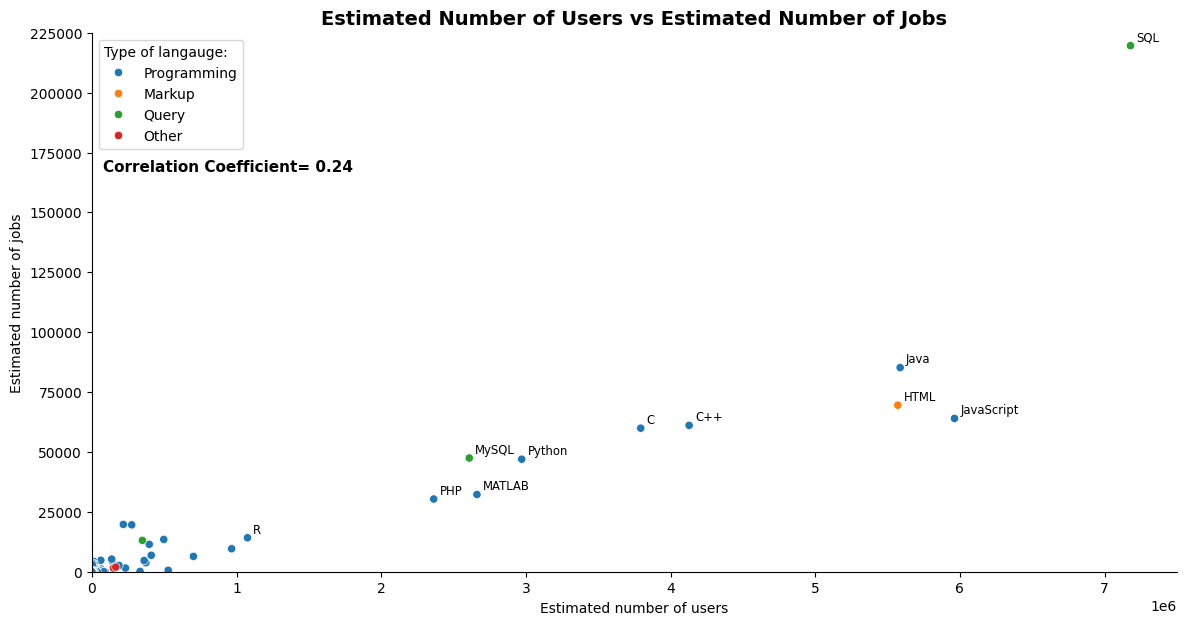

In [17]:
## user numbers vs jobs scatter chart
notable = df.copy().reset_index()
notable['type'] = notable['tags'].apply(lambda x: x if (x in ['pl','textMarkup','queryLanguage']) else 'other')

fig = plt.figure(figsize=(14,7))
ax = sns.scatterplot(x=notable['numberOfUsersEstimate'],y=notable['numberOfJobsEstimate'],hue=notable['type'])
fig.add_axes(ax)

handles,_= ax.get_legend_handles_labels()
ax.legend(handles= handles, labels = ['Programming','Markup','Query','Other'],title="Type of langauge: ",alignment='left',loc='upper left')
ax.set_ylim(0,225000); ax.set_ylabel("Estimated number of jobs")
ax.set_xlim(0,7500000); ax.set_xlabel("Estimated number of users")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title("Estimated Number of Users vs Estimated Number of Jobs",**TITLE_FONT)

coeff = np.round(scipy.stats.spearmanr(notable['numberOfUsersEstimate'],notable['numberOfJobsEstimate']), 2)
ax.annotate(xy=(80000,167000),text=f'Correlation Coefficient= {coeff[0]}',fontsize=11,fontweight='semibold')

for point in range(0,notable.shape[0]):
     if notable.loc[point,"numberOfUsersEstimate"] > 1000000:
          ax.text(notable.loc[point,"numberOfUsersEstimate"]+40000, notable.numberOfJobsEstimate[point]+2000, 
          notable.name[point], horizontalalignment='left',  size='small', color='black')

Another metric we could look as is the average number of daily page views on wikipedia. Although this does not directly impact how much the langauge is used, it could give us an indication as to how prominent the language is in the public conscience, and if people are actively searching out infomation about it. 

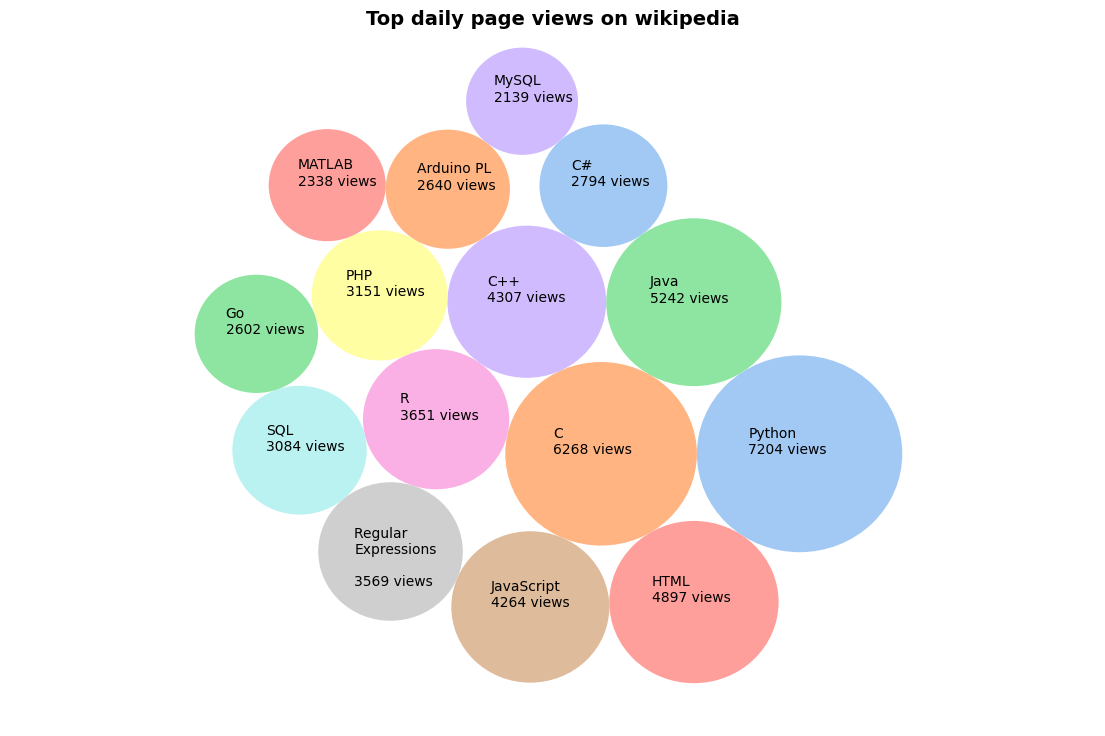

In [18]:
biggest_views = df[['name','wikipedia_dailyPageViews','tags']].nlargest(15,'wikipedia_dailyPageViews',keep='all')
magnitudes, labels = biggest_views['wikipedia_dailyPageViews'].to_list(), biggest_views['name'].to_list()
circles = (circlify.circlify(magnitudes))[::-1]

fig , ax = plt.subplots(figsize=(14,9))
ax.set_xlim(-1.5,1.5); ax.set_ylim(-1,1)
ax.axis('off')
ax.set_title("Top daily page views on wikipedia",**TITLE_FONT)

for idx,(circle,size,language) in enumerate(zip(circles,magnitudes,labels)):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, linewidth=3, fc=PASTELS[idx % 10])) 
    if len(language) < 15:
        ax.annotate(xy=(x-(r/2),y),text=f"{language}\n{int(size)} views")
    else: ax.annotate(xy=(x-(r/2),y-(r/2)),text=f"{language[0:8]}\n{language[8:19]}\n{language[20:]}\n{int(size)} views")

The PLDB provides their own ranking system for the programming language, although from the documentation it's not entirely clear how this is calculated. This ranking system could be seen as an indicator of popularity, as the highly ranked languages have something popular about them for PLDB to rate them so highly out of thousands of languages. For the top 15 ranked langauges, I looked at a handful of metrics to see which ones seem to be most influencial when it comes to a language achieving a high ranking.

From the slope chart, we see that github statistics seem to have little bearing on the ranking between these 15, with most of the languages performing well on github, falling fairly low on the final ranking charts. Having a lot of other languages built using that language seems to help ranking, as the best performing langauges here tended to finish higher. However this is mainly speculation as we don't know how these values were calculated for sure. It's also worth remembering that all of these ranking are done relative to the other 14 languages in the ranking, and so these are not the overall category rankings for all the languages in the database.

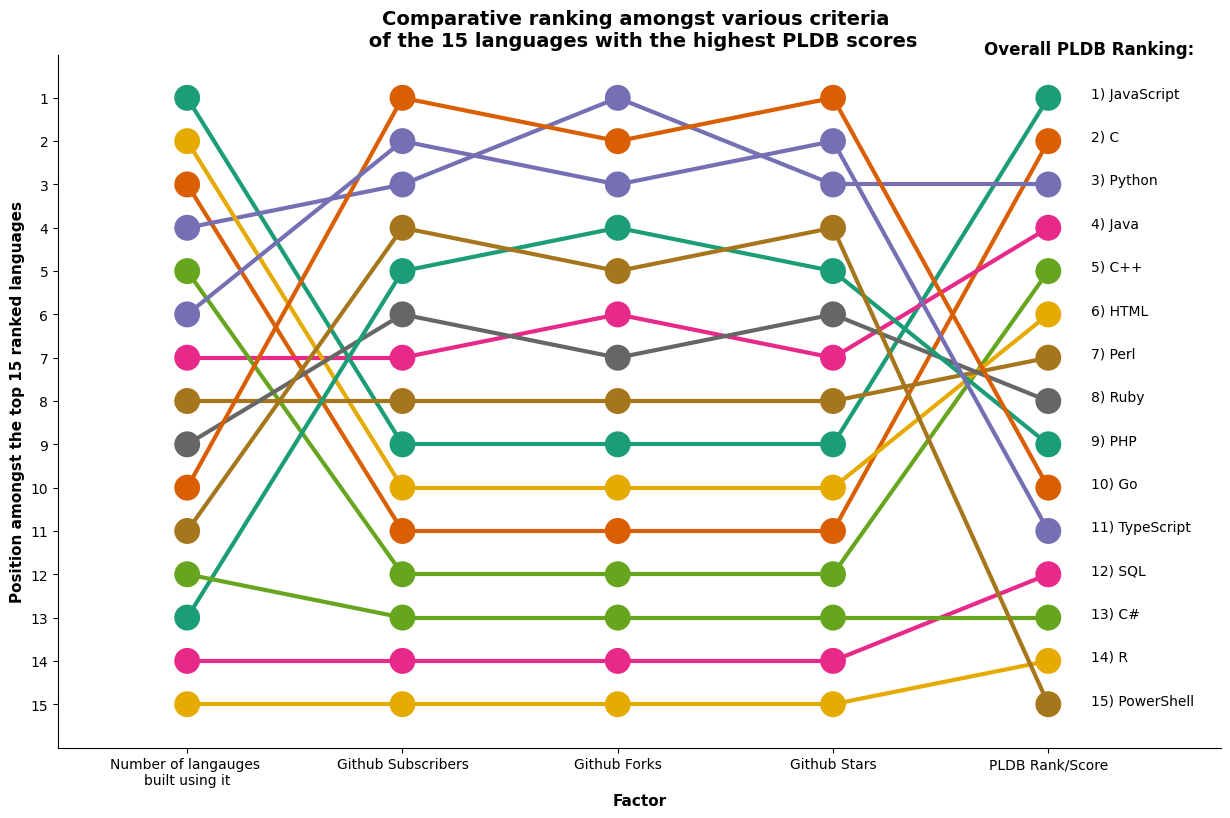

In [19]:
fig, ax = plt.subplots(figsize=(15,9))
metrics = ['foundationScore','githubRepo_subscribers', 'githubRepo_forks', 'githubRepo_stars','rank']
top_ranked = df[(['name'] + metrics)].nsmallest(15,'rank')

for x,asc in zip(metrics,[False,False,False,False,True]):
    top_ranked = top_ranked.sort_values(x,ascending=asc)
    top_ranked[x] = np.arange(1,16)
top_ranked.set_index(keys='name',inplace=True)

ax.set_xlim(-1,26); ax.set_ylim(0,16)
ax.set_yticks(ticks=np.arange(1,16), labels=np.char.mod('%d', np.arange(15,0,-1)))
ax.set_xticks(ticks=np.arange(2,23,5),labels=['Number of langauges \nbuilt using it','Github Subscribers','Github Forks','Github Stars','PLDB Rank/Score'])
ax.set_xlabel("Factor",fontweight='bold',fontsize=11); ax.set_ylabel("Position amongst the top 15 ranked languages",fontweight='bold',fontsize=11)
ax.set_title("Comparative ranking amongst various criteria \n of the 15 languages with the highest PLDB scores",**TITLE_FONT)
ax.spines[['right', 'top']].set_visible(False)
ax.annotate(xy=(20.5,16),text="Overall PLDB Ranking: ",fontweight='semibold',fontsize=12)

for line, (name,colour) in enumerate(zip(top_ranked.index.to_list(),(COLOUR_SET*5))):
    centres = [top_ranked.loc[name,col] for col in metrics]
    for x_offset,y_value in enumerate(centres): 
        ax.add_patch(plt.Circle((x_offset*5 + 2,(16-y_value)),0.3,fc=colour))
        if x_offset < len(centres) - 1:
            ax.add_line(plt.Line2D(np.linspace(x_offset*5 + 2, (x_offset+1)*5 + 2,10), np.linspace(16-centres[x_offset],16-centres[x_offset + 1],10),linewidth=3,color=colour))
    ax.annotate(xy=(23,15-line),text=f"{line+1}) {name}",fontweight='roman')
    

A final metric I had wanted to look at when it comes to the popularity of languages was how much literature had been produced surrounding each language(e.g books and papers written). Ideally I wanted to create some sort of graph looking at the ratio between number of users and amount of literature produced to see which userbases were the most proactive in creating material surrounding their language. However, a quick look at the data showed this was not going to be possible for two reasons; one was that clearly the method used to collect data on the number of books/papers written had not worked correctly as many big languages reported to have had hardly any books written (which is not true), and the other was that for the smaller languages the number of user estimate was only 1, which makes it very difficult to actually gauges the ratios, as in reality these numbers will be in the couple of hundred/thousands at least.

In [20]:
comparison = df[['name','paperCount','bookCount','numberOfUsersEstimate']].copy()
comparison['literature'] = comparison['bookCount'] + comparison['paperCount']
comparison['lit_ratio'] = ((comparison['literature'] / comparison['numberOfUsersEstimate']) * 10000).round(5)
comparison.dropna(subset=['lit_ratio'],inplace=True)
comparison = comparison[(comparison['lit_ratio'] > 0.00005)& (comparison['lit_ratio'] != np.inf)]
comparison.sort_values('lit_ratio',ascending=False)

,name,paperCount,bookCount,numberOfUsersEstimate,literature,lit_ratio
2453,frame,12.0,0.0,1,12.0,120000.00000
3660,coherence,11.0,0.0,1,11.0,110000.00000
2700,empirical,0.0,5.0,1,5.0,50000.00000
2721,links,5.0,0.0,1,5.0,50000.00000
2679,AspectC++,5.0,0.0,1,5.0,50000.00000
...,...,...,...,...,...,...
125,SaltStack,0.0,1.0,34669,1.0,0.28844
1,C,19.0,78.0,3793768,97.0,0.25568
5,HTML,7.0,116.0,5570873,123.0,0.22079
64,SPSS,5.0,14.0,965674,19.0,0.19675


## Origins 

Next I wanted to look at when and where programming languages tend to be created, and if there is any link between the origins of the most popular languages.

Firstly, we look at the number of languges appearing each year. Obviously programming languages are fairly revent inventions, with the first one in our dataset appearing in 1948. From the histogram we see that there was a big boom in the number of languages appearing in 1985-1990, which then slowly declined until the 2010s, when the numbers shot up again. 2019 saw 111 languages appearing in that year, the highest to date. The number of languages appearing in the 2020s seem to have dropped off quite dramatically, but this may just be due to the database not being fully updated recently. 

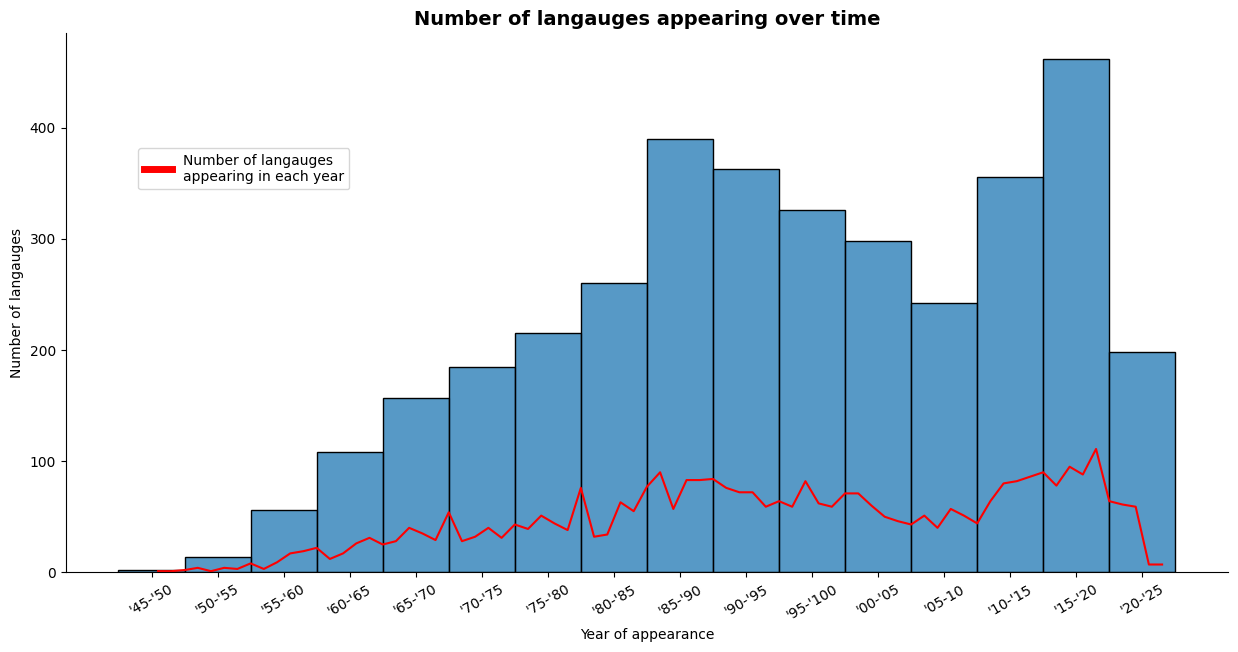

In [21]:
## histogram of date of appearance 
fig = plt.figure(figsize=(15,7))
ax = sns.histplot(df['appeared'],binwidth=5,binrange=(1945,2025))
fig.add_axes(ax)

# no. of languages created in each year
app_years = df['appeared'].value_counts().sort_index()
sns.lineplot(ax=ax,data=app_years,color='red')
ax.set_xticks(ticks=np.arange(1947.5,2027.5,5),labels=[f"'{x}-'{x+5}" for x in(np.arange(45,100,5))] + ["'00-'05","'05-10"] + [f"'{x}-'{x+5}" for x in(np.arange(10,25,5))])
ax.tick_params(axis='x',rotation=30)
ax.set_xlabel("Year of appearance"); ax.set_ylabel("Number of langauges")
ax.set_title("Number of langauges appearing over time",**TITLE_FONT)
ax.legend(handles=[(plt.Line2D([0],[0],c='red',linewidth=5))],labels=['Number of langauges \nappearing in each year'],bbox_to_anchor=(0.25,0.8),loc='upper right')
ax.spines[['top','right']].set_visible(False)

We see that a lot of the most used langauges appeared during the 1990s, all around the same time. It's interesting to see that a few langauges are still very popular despite beingn very old, at least comparatively, with SPSS appearing in 1968 and still being widely used today. All of the 15 most used langauges are at least a decade old, so no new langauges have been able to monopolise the market very quickly. This makes sense, as businesses don't want to frequently switch to new langauges all the time when older, tried and tested langauges are still perfectly good. It's interesting to see all of these langauges are still recieving updates, as they have all had activity since 2022. This may explain why these languages have such a large userbase, as they are constantly updated to become eaier to use and incorporate more features. 

Country of origin markers were also added to each of the languages and we can quite clearly see most of the most used languages were made in the United States. This makes sense as they have been at the forefront of computer science for quite some time. However there are a few other countries from which a popular langauge has emanated, showing that the US doesn't have a monopoly over the popular languages.

In [22]:
most_used_df = df.nlargest(15,'numberOfUsersEstimate',keep='all')[::-1]
labels = most_used_df['name'].to_list()
start_dates = most_used_df['appeared'].to_list()
end_dates = most_used_df['lastActivity'].to_list()
country_of_origin = most_used_df['country'].to_list()
images_raw = [plt.imread(f'../images/{path}.png') for path in ['canada','italy','netherlands','swiss','unknown','usa']]
[can,ita,ned,sui,ukn,usa] = [mbox.OffsetImage(im, zoom = zoom)  for (im,zoom) in zip(images_raw,[0.04,0.11,0.06,0.12,0.03,0.037])]

COUNTRY_IMAGES = dict([('United States',(usa,'blue')),("Italy",(ita,"green")),(np.nan,(ukn,'grey')),("Canada",(can,'orange')),("Switzerland",(sui,'red')),("Netherlands",(ned,'purple'))])

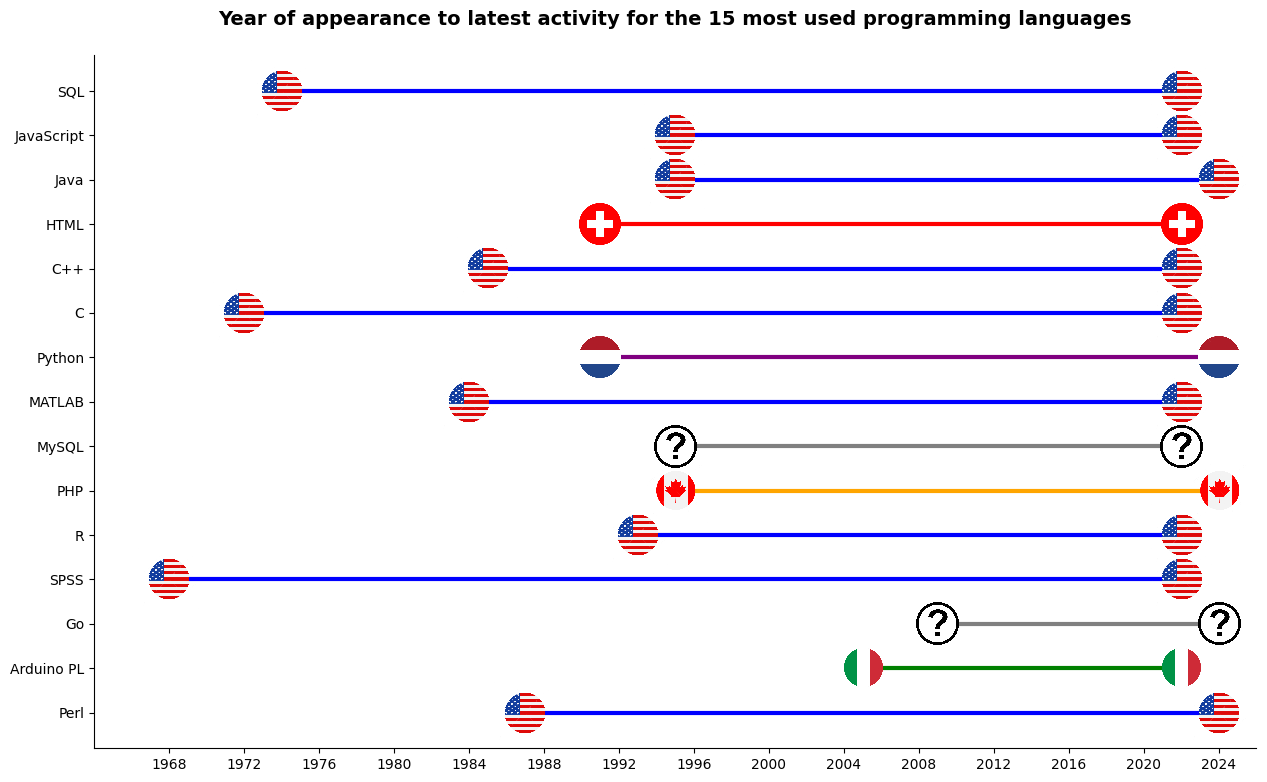

In [23]:
most_used_df = df.nlargest(15,'numberOfUsersEstimate',keep='all')[::-1]
labels = most_used_df['name'].to_list()
start_dates = most_used_df['appeared'].to_list()
end_dates = most_used_df['lastActivity'].to_list()

fig , ax = plt.subplots(figsize=(15,9))
ax.set_xlim(1964,2026),ax.set_ylim(-1,38)
ax.set_yticks(ticks = np.arange(0,37,2.5) + 1,labels=labels)
ax.set_xticks(ticks=np.arange(1968,2028,4))
ax.spines[['right', 'top']].set_visible(False)
ax.set_title("Year of appearance to latest activity for the 15 most used programming languages\n",**TITLE_FONT)

for idx,(start,end,language,country) in enumerate(zip(start_dates,end_dates,labels,country_of_origin)):
    height = idx*2.5 + 1
    ax.add_artist(mbox.AnnotationBbox(COUNTRY_IMAGES[country][0], (start, height), frameon=False))
    ax.add_artist(mbox.AnnotationBbox(COUNTRY_IMAGES[country][0], (end, height), frameon=False))
    ax.add_line(plt.Line2D(np.linspace(start,end,10),[height],linewidth=3,color=COUNTRY_IMAGES[country][1]))

Looking globally at where languages tend to originate from, we see that North America and Europe are both big players, with the USA blowing the other countrie out of the water. In fact I had to use a log scale for the number of langauges created, as without this the USA outweighed every other country by so much that they were hardly visable on the map. Canada, the UK, Australia, France , Germany and Japan are also big contributors of langauges. Interestingly, for their population China and India have contributed relatively little in the way of langauges.

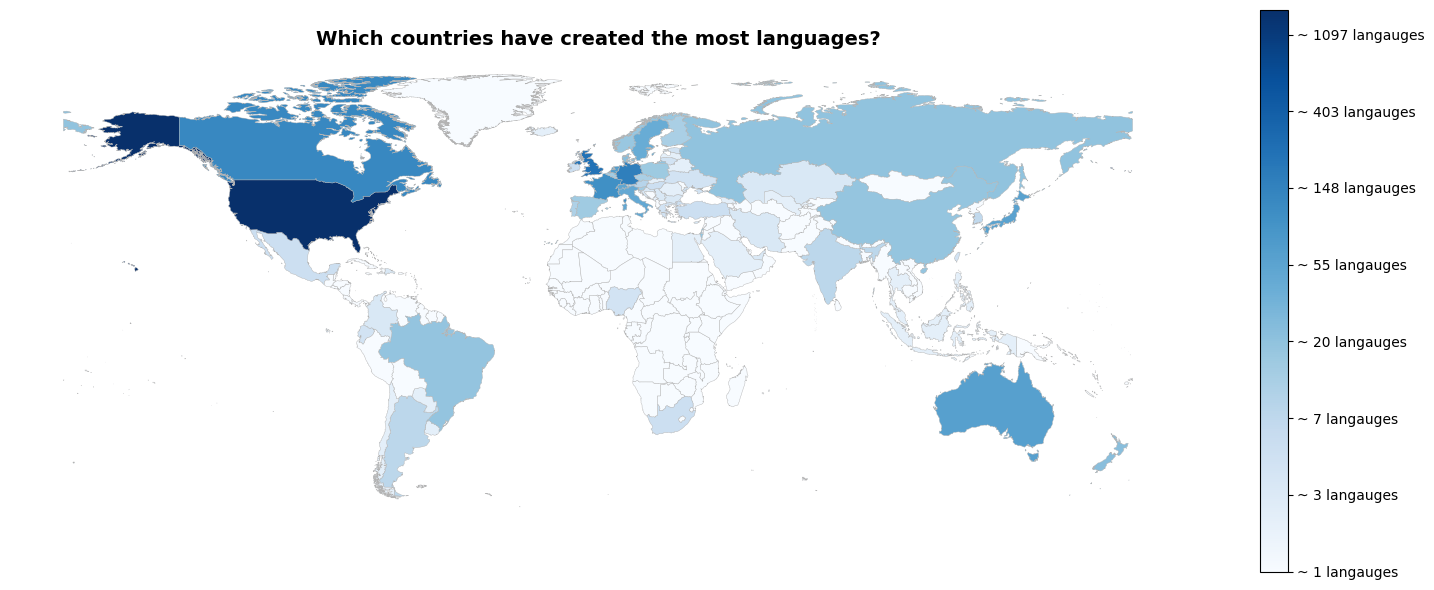

In [50]:
map_file = geopandas.read_file("../map files/world-administrative-boundaries.shp")[['name','color_code','geometry']]
all_countries = map_file['name'].to_list()

x = countries[['1','2','3','4','5','6']].melt(value_name='name')['name'].value_counts().reindex(all_countries,fill_value=0).reset_index()
x['count'] = np.log(x['count'] + 1 )
y  = map_file.merge(x,on='name')

fig, ax = plt.subplots(figsize=(15,6))
ax.spines[['right', 'top','bottom','left']].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])
ax.set_title("Which countries have created the most languages?",**TITLE_FONT)
y.plot(column='count',cmap='Blues', ax=ax,edgecolor="0.7",linewidth=0.3)

bar_info = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=x['count'].max()))
cbar = fig.colorbar(bar_info,ax=ax,ticks=[0,1,2,3,4,5,6,7],format=lambda x,_ : f"~ {round(np.exp(x))} langauges")
fig.tight_layout()

Since the above map doesn't quite display the sheer dominance of the USA when it comes to being involved in the creation of programming langauges I wanted to create a  dot matrix to emphasise just how many languages the USA have have had a hand in (41.6% of those listed in the PLDB).

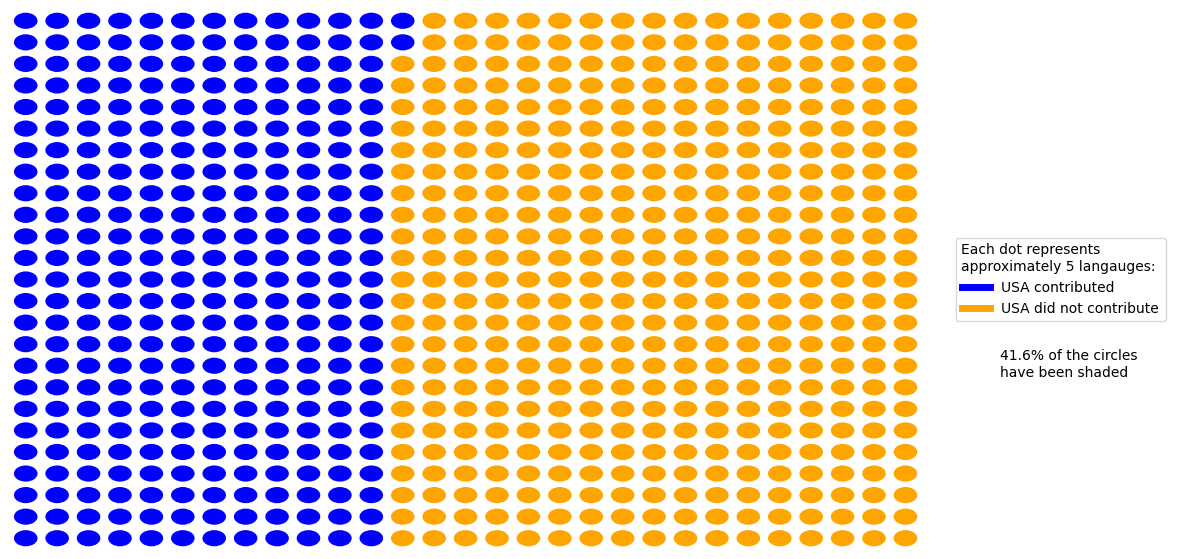

In [25]:
usa_original = x[x['name'] == 'United States of America']['count'].values[0]
usa_contributions = (int(np.exp(usa_original)-1))
total_langauges = countries['name'].shape[0]
shaded = usa_contributions / 5
percent = round(usa_contributions/total_langauges * 100,1)

fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlim(-1,73); ax.set_ylim(4,54)
ax.legend(handles=[plt.Line2D([0],[0],c='blue',linewidth=5),plt.Line2D([0],[0],c='orange',linewidth=5)],
          labels=['USA contributed', 'USA did not contribute'], loc='center right',title="Each dot represents \napproximately 5 langauges: ")
ax.annotate(xy= (62,20),text=f"{percent}% of the circles\nhave been shaded")
ax.spines[['right', 'top','left','bottom']].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

shaded_counter = 0
for x_coord in range(0,29):
    for y in range(24,-1,-1):
        if shaded_counter < shaded:
            ax.add_patch(plt.Circle((x_coord*2,y*2 + 5),0.75,fc='blue'))
            shaded_counter += 1
        else: ax.add_patch(plt.Circle((x_coord*2,y*2 + 5),0.75,fc='orange'))

It may also be interesting to see if a lot of langauges have originated from any individual person. We see that Niklaus Wirth is by far the leader in this category, having created 9 languages, which are listed on the chart. John Backus and Wouter Van Oortmerssen have also contributed to the created of a lot of langauges, 6 apiece. 

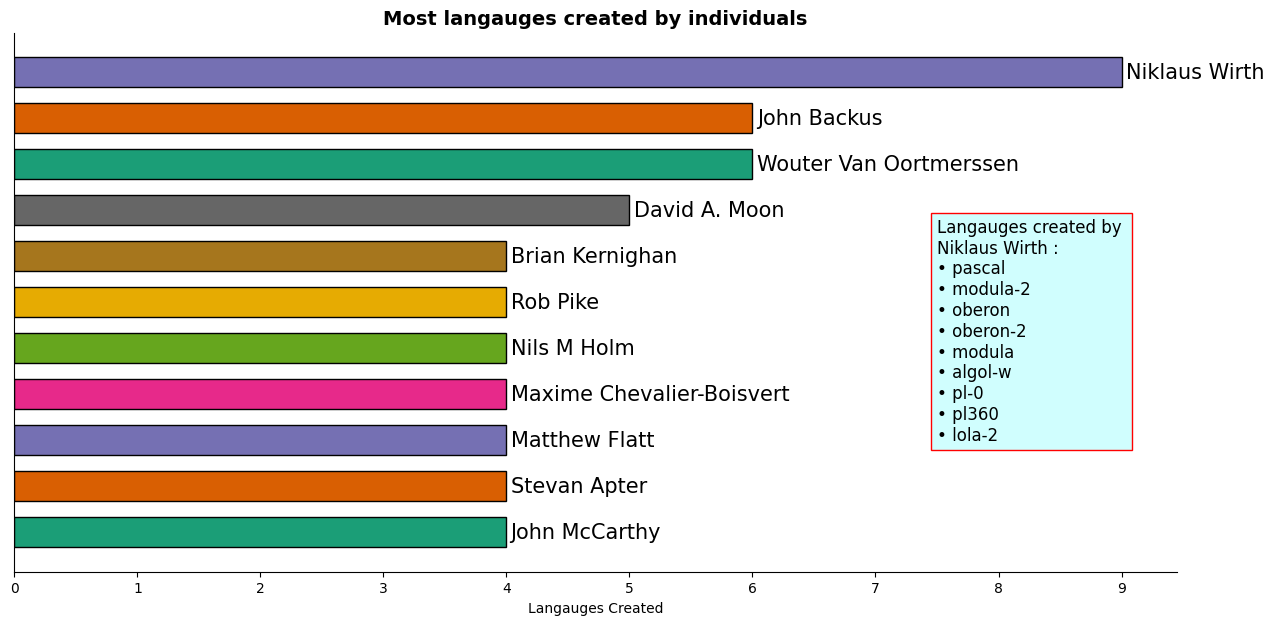

In [26]:
creators = df[creator_list].melt().groupby('value').size().sort_values().nlargest(10,keep='all')[::-1]
niklaus = df[df[[f'creator{x}' for x in range(0,12)]].isin(['Niklaus Wirth']).any(axis=1)]['id'].to_list()
fig, ax = plt.subplots(figsize=(15,7))

rects = ax.barh(np.arange(creators.size), creators.values,0.65,color=COLOUR_SET,edgecolor='black')
ax.bar_label(rects, padding=3,fontsize=15,labels= creators.index.to_list())
ax.set_title("Most langauges created by individuals",**TITLE_FONT)
ax.set_yticks([]); ax.set_xticks(np.arange(0,10,1)) ;ax.set_xlabel("Langauges Created")
ax.spines[['right', 'top']].set_visible(False)

ax.text(x=7.5,y=2,s=f"Langauges created by \nNiklaus Wirth : \n• {'\n• '.join(niklaus)} ", bbox=dict(facecolor='xkcd:pale blue',edgecolor='red'),fontdict=dict(fontsize=12)); 

## Common features across langauges

Finally I want to look at the features included in programming langauges to see what seems to be common across everything and if there's anything that langauges seem to all do differently

The PLDB includes a lot of boolean values telling us whether a certain feature is included in a language. The table below shows how many of the languages contain each feature. All the features listed are extremely popular, with virtually every langauge having comments, print debugging and strings. Fewer have semantic indentation, but it is still a very large majority (88%). Being open source is also very common, with 98% purporting that they are.

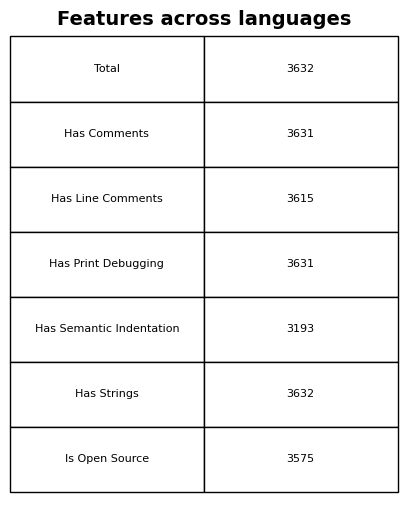

In [27]:
features = ['hasComments', 'hasLineComments', 'hasPrintDebugging','hasSemanticIndentation', 'hasStrings','isOpenSource']
x = df[(df['hasComments']) | (df['hasStrings'])].agg({'name': 'count',**dict.fromkeys(features,'sum')}).to_numpy()
labels = np.array(["Total","Has Comments", "Has Line Comments", "Has Print Debugging","Has Semantic Indentation", "Has Strings", "Is Open Source"])
data = np.concatenate((labels,x)).reshape(2,7).transpose()

fig,ax = plt.subplots(figsize=(5,6))
ax.axis('off')
ax.set_title("Features across languages",**TITLE_FONT)
table = ax.table(cellText=data ,loc='center',cellLoc='center')
table.scale(1,3.9)

Out of interest, I wanted to see which languages was the one missing comments and we see here that it's regex. 

In [28]:
df[~df['hasComments']]

,id,name,appeared,measurements,tags,foundationScore,exampleCount,rank,lastActivity,writtenInCount,...,creator3,creator4,creator5,creator6,creator7,creator8,creator9,creator10,creator11,creator12
263,regex,Regular Expressions,1951,17,queryLanguage,0,2,264,2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some of the languages have the token used to denote strings, comments and print tokens in the PLDB. This is far from most the langauges, so the graph below should be taken with a pinch of salt. However from that sample it seems like there is a lot of homogony between the langauges when it comes to string tokens, with " being the most popular by far. There is a more variance when it comes to comment tokens, with // only just coming out on top. However there is very little conformity with print tokens, with 117 different ways of signalling a print statement. For comparison,there were only 21 ways of signalling comments, and just 6 to signal strings. 

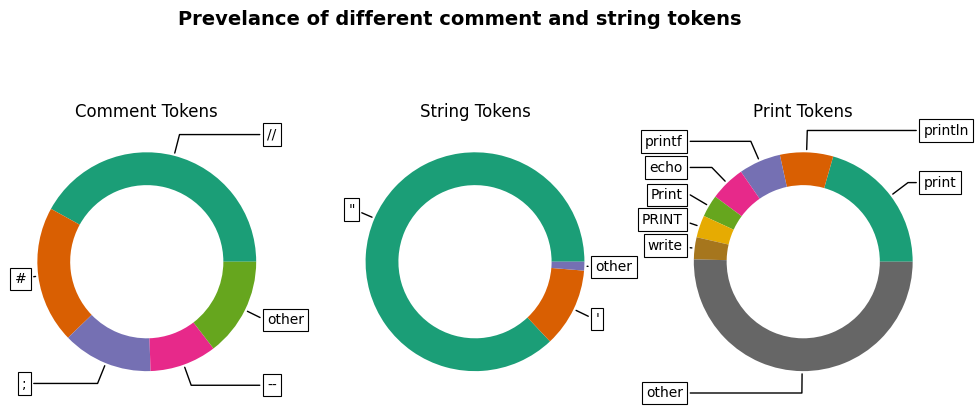

In [31]:
fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(12,9))
fig.suptitle("Prevelance of different comment and string tokens",**TITLE_FONT)

def make_chart(axis,col,title,boundary=20):
    tokens = df[~df[col].isnull()][col].value_counts()
    other_values = tokens[tokens < boundary].sum()
    data = pd.concat([tokens[tokens >= boundary], pd.Series({'other' : other_values})],axis=0)
    wedges, _ = axis.pie(x=data,wedgeprops=dict(width=0.3),colors=COLOUR_SET)
    axis.set_title(title)
    labels = data.index.to_list()
    #from pieplot documentation (build the boxes around the labels)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.8)
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        axis.annotate(labels[i], xy=(x, y), xytext=(1.1*np.sign(x), 1.2*y),
                    horizontalalignment=horizontalalignment, **kw)

make_chart(ax1,'lineCommentToken',"Comment Tokens")
make_chart(ax2,"stringToken","String Tokens")
make_chart(ax3,"printToken","Print Tokens",10)
fig.subplots_adjust(top=0.9,bottom=0.5)

## Conclusion 

From dataset and the graphs, we are now able to draw together some answers to the questions we asked.

- When it comes to popularity, SQL, Java and Javascript are the top three in terms of both number of users and number of jobs. This would seem to indicate they are the most popular in businesses and day-to-day life. The vast majority of widely used langauges are programming languages, with a few notable query and markup languages breaking through as well. Python and C also appear to be popular and well-known, with the highest average daily wikipedia page views, supported by a high number of users.

- The average programming languages originates from the US or Europe, and was likely made in the 90s or the 2010s. There is quite a spread though with no particular year having an outlandishly high number of languages appear in that period. The geographical spread is less pronounced, with the US and Europe producing far more languages than other regions, although Brazil, China and Australia have all made quite a few languages themselves. 

- It seems that pretty much every single langauges has comments, prints and string. This makes sense as these features tend to be considered necessary to have a working programming language. However when it comes to the actual symbol used to denote these features, there can be far bit of variation in the way that strings and printing are handled whereas Strings overwhelmingly use ". Suprisingly the vast, vast majority of langauges are also open source.

The dataset for this notebook comes from : https://pldb.io/csv.html . This occasionally updates so some of the exact number in this notebook could be outdated, but it is unlikely the general trends and patterns will have changed significantly.